In [1]:
# The line `# !pip install --upgrade -q numpy numba polars lightgbm tensorflow-addons` is a command that installs or upgrades several Python packages.
# !pip install --upgrade -q numpy numba polars lightgbm tensorflow-addons

In [2]:
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm
import gc
import json
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import gc
import os
import sys
sys.path.append('..')

from src import metric_fast
import joblib
import time
import importlib
importlib.reload(metric_fast)

2023-12-14 16:49:30.818246: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports 

<module 'src.metric_fast' from '/home/sleep-kaggle/kaggle_final_solution/../src/metric_fast.py'>

In [4]:
class cfg:
    samp_freq=1
    gaussian_overlay_len = 60
    std_dev_num = 2400
    ver='fm-v21-final'

In [ ]:
settings_json = json.load(open('../settings.json', 'r'))
print(settings_json)

for k,v in settings_json.items():
    setattr(cfg, k, v)
    
print(cfg.__dict__)

In [ ]:
%%time
train_events = pl.read_ipc(os.path.join(cfg.processed_data_path, 'train_events.ipc'))

In [5]:
splits_df = train_events[['series_id']].unique(maintain_order=True)
splits_df = splits_df.to_pandas()

for n_splits in [5, 7, 10]:
    folds = KFold(n_splits, shuffle=True, random_state=258)

    splits_df[f'{n_splits}_fold'] = 0
    for i, (trn_idx, val_idx) in enumerate(folds.split(splits_df['series_id'], splits_df['series_id'])):
        
        splits_df.loc[val_idx, f'{n_splits}_fold'] = i+1
                                       
    
splits_df = pl.DataFrame(splits_df)             

In [6]:
def load_data(directory):
    X_s = []
    y_s = []
    series_ids = []

    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('_X.npy'):
            series_id = filename.split('_X.npy')[0]
            X = np.load(os.path.join(directory, filename))
            y = np.load(os.path.join(directory, f'{series_id}_y.npy'))

            X_s.append(X)
            y_s.append(y)
            series_ids.append(series_id)

    return X_s, y_s, series_ids

In [7]:
def normalize_y(y):
    
    for i in range(y.shape[1]):
        
        mean = y[:,i].mean()
        std = y[:,i].std()
        y[:,i] = (y[:,i]-mean)/(std+1e-16)
    
    return y

In [8]:
_ = gc.collect()

In [9]:
def split_and_pad(X, y=None, split_length=1440, stride=1440):
    """
    Splits and pads the arrays X and y using a sliding window.

    Parameters:
    - X (np.array): Array with shape (timesteps, features)
    - y (np.array): Array with shape (timesteps, 2)
    - split_length (int): Desired timestep length for the resulting arrays.
    - stride (int): Step size for sliding window.

    Returns:
    - List of arrays for X and y, each with shape (split_length, features)
    """
    
    if y is not None and len(X) != len(y):
        raise ValueError("X and y should have the same number of timesteps.")
    
    timesteps, features = X.shape
    
    # Create empty lists to store split segments
    X_splits = []
    y_splits = []
    starts = []
    
    # Use sliding window to extract segments
    
    for start in range(0, timesteps, stride):
        end = start + split_length
        if end <= timesteps:
            starts.append(start)
            X_splits.append(X[start:end].copy())
            if y is not None:
                y_splits.append(y[start:end].copy())
        else:
            # If the segment is shorter than split_length, pad it
            starts.append(start)
            padding_length = end - timesteps
            X_segment_padded = np.pad(X[start:], ((0, padding_length), (0, 0)), mode='constant', constant_values=-9)
            X_splits.append(X_segment_padded)
            
            if y is not None:
                y_segment_padded = np.pad(y[start:], ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                y_splits.append(y_segment_padded)
                
            break
            
            
    if y is not None:
        return X_splits, y_splits, starts
    
    return X_splits, starts



class SleepDataset:
    
    def __init__(self, X_s, y_s=None, series_ids=None, samp_freq=None, remove_no_dets=True, is_train=False, split_factor=1, norm_params=None):
        
        self.split_len = (24*60*12) // cfg.samp_freq
        self.split_strides = self.split_len
        self.remove_no_dets = remove_no_dets
        self.is_train = is_train

        print(f'Using a split len of {self.split_len}')
        self.create_dataset(X_s, y_s, series_ids)

        if self.is_train:
            self.norm_params = self.calculate_norm_params()
        else:
            if norm_params is None:
                raise ValueError("Normalization parameters must be provided for non-training data.")
            self.norm_params = norm_params

        self.normalize_data()

    def calculate_norm_params(self):
        mean = np.mean(self.X, axis=(0, 1))
        std = np.std(self.X, axis=(0, 1))
        return {'mean': mean, 'std': std}

    def normalize_data(self):
        self.X = (self.X - self.norm_params['mean']) / (1e-6 + self.norm_params['std'])
        
        
    def create_dataset(self, X_s, y_s=None, series_ids=None):
        X_s_splits, y_s_splits, series_splits, starts_splits = [], [], [], []

        for i in tqdm(range(len(X_s))):
            x_splits, starts = split_and_pad(X_s[i].copy(), split_length = self.split_len, stride=self.split_strides)
            X_s_splits.extend(x_splits)
            starts_splits.extend(starts)

            if y_s is not None:
                _, y_splits, _ = split_and_pad(X_s[i].copy(), y_s[i].copy(), split_length=self.split_len, stride=self.split_strides)
                y_s_splits.extend(y_splits)

            if series_ids is not None:
                series_splits.extend([series_ids[i] for _ in range(len(x_splits))])
            
        self.X = np.array(X_s_splits)
        self.starts_splits = np.array(starts_splits)
        
        if y_s is not None:
            self.y = np.array(y_s_splits)

            if self.remove_no_dets:
                fltr = (self.y[:, :, 1].sum(axis=1) + self.y[:, :, 0].sum(axis=1)) != 0
                self.X = self.X[fltr]
                self.y = self.y[fltr]
                if series_ids is not None:
                    self.series_ids = np.array(series_splits)[fltr]
                else:
                    self.series_ids = None
            
            self.y = np.array([normalize_y(yts) for yts in self.y])

        else:
            self.y = None

        if series_ids is not None:
            if not hasattr(self, 'series_ids'):
                self.series_ids = np.array(series_splits)
            print(f'X: {self.X.shape}, y: {self.y.shape if self.y is not None else "Not provided"}, series_ids: {self.series_ids.shape}')
        else:
            print(f'X: {self.X.shape}, y: {self.y.shape if self.y is not None else "Not provided"}')

In [10]:
def nms_nikhil(preds_orig, k_orig=125, max_thresh=0.05, max_count=1000):
    
    preds=preds_orig.copy()

    count = 0
    base=6.75
    
    k = k_orig
    prev_max = None

    scores = []
    indices = []
    
    while True:
            
        curr_max_idx = np.argmax(preds)
        curr_max = preds[curr_max_idx] 
        
        if (curr_max < max_thresh) or count > max_count:
            break
        
        indices.append(curr_max_idx)
        scores.append(curr_max)
        
        preds[curr_max_idx] = 0
        
        supress_rates = np.logspace(start=0, stop=1, num=k, base=base)/base

        preds[max(curr_max_idx-k, 0):curr_max_idx] *= supress_rates[:min(k, curr_max_idx-0)][::-1]
        preds[curr_max_idx+1:min(curr_max_idx+k+1, preds.shape[0])] *= supress_rates[:min(k, preds.shape[0]-curr_max_idx-1)]

        prev_max = curr_max
        
        count += 1
        
    return indices, scores

def get_actual_preds(val_preds, val_series_ids, val_steps, type_):
    times = []
    series_ids = []
    scores = []
    scores_y = []
    
    for i in np.arange(len(val_preds)):
        
        vp_i = val_preds[i]
        ser_id = val_series_ids[i]
        
        col_index = 0 if type_ == "onset" else 1
        other_col_index = 1 if type_ == "onset" else 0
        
        preds = vp_i[:, col_index]
        preds_other = vp_i[:, other_col_index]

        height_thresh = 0.05
        
        peaks, peak_scores = nms_nikhil(preds)

        times.extend(val_steps[i][peaks])
        scores.extend(list(peak_scores))
        series_ids.extend([ser_id] * len(peaks))

    return np.array(series_ids), np.array(times), np.array(scores)


def post_process_preds(val_events_df, val_preds, val_series_ids, val_starts_splits, samp_freq, get_score=False):
    
#     val_steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(val_preds.shape[0])])

    val_res = []
    
    prev_ser_id = None
    
    res_steps = []
    res_preds = []
    res_series_ids = []
    
    start = 0
    while start < len(val_preds):
        
        end = start+1
        while end < len(val_preds) and val_series_ids[end] == val_series_ids[start]:
            end += 1
            
        preds = val_preds[start:end]
        
        steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(start, end)])
        preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
        
        res_preds.append(preds)
        res_steps.append(steps)
        res_series_ids.append(val_series_ids[start])
        
        start=end
        
        
#     print(len(res_series_ids), len(res_steps), len(res_preds))

    series_ids_onsets, onsets,  scores_onsets = get_actual_preds(res_preds, res_series_ids, res_steps, 'onset')
    series_ids_wakeups, wakeups,  scores_wakeups =get_actual_preds(res_preds, res_series_ids, res_steps, 'wakeup')
    
    
    onset_preds = pl.DataFrame().with_columns([pl.Series(series_ids_onsets).alias('series_id'),
                                           pl.Series(onsets).cast(pl.Int64).alias('step'),
                                           pl.lit('onset').alias('event'),
                                           pl.Series(scores_onsets).alias('score')])

    wakeup_preds = pl.DataFrame().with_columns([pl.Series(series_ids_wakeups).alias('series_id'),
                                               pl.Series(wakeups).cast(pl.Int64).cast(pl.Int64).alias('step'),
                                               pl.lit('wakeup').alias('event'),
                                               pl.Series(scores_wakeups).alias('score')])
    
    val_preds_df = pl.concat([onset_preds, wakeup_preds]).sort(by=['series_id', 'step'])
    
    if get_score:
        toleranaces = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
        comp_score = metric_fast.comp_scorer(
        val_events_df,
        val_preds_df,
        tolerances = toleranaces,
        )
        return comp_score
    
    else:
        return val_preds_df

In [11]:
def calculate_exponential_lr(start_lr, end_lr, num_steps, decay_rate=None):
    """
    Calculate the exponentially decreasing learning rates.

    Parameters:
    start_lr (float): Initial learning rate.
    end_lr (float): Final learning rate.
    num_steps (int): Total number of steps over which the learning rate should decay.
    decay_rate (float): Decay rate per step. If None, it will be computed based on start_lr, end_lr, and num_steps.

    Returns:
    list: A list containing the learning rate for each step.
    """
    if decay_rate is None:
        # Calculate decay rate based on the start_lr, end_lr, and num_steps
        decay_rate = (end_lr / start_lr) ** (1 / (num_steps - 1))

    learning_rates = [start_lr * (decay_rate ** step) for step in range(num_steps)]
    return learning_rates



In [12]:
class IntervalEvaluation(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, val_events_df, samp_freq, n_steps, start_lr, end_lr):

        super(tf.keras.callbacks.Callback, self).__init__()
        self.val_ds = val_ds
        self.val_events_df = val_events_df
        self.samp_freq = samp_freq
        
        warmup_pct_steps = 0.25
        warmup_steps = int(n_steps * warmup_pct_steps)
        self.learning_rates = [start_lr] * (warmup_steps) + calculate_exponential_lr(start_lr, end_lr, n_steps-warmup_steps)
        self.best_score = -np.inf
        self.best_model = None
        self.step_count=0

    def on_epoch_begin(self, epoch, logs={}):

        self.start_time = time.time()
        
        if epoch == 0:
            self.first_epoch_start_time = self.start_time
        
    def on_train_batch_begin(self, batch, logs=None):
        if self.step_count < len(self.learning_rates):

            tf.keras.backend.set_value(self.model.optimizer.lr, self.learning_rates[self.step_count])
            self.curr_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.step_count += 1
    
    def on_epoch_end(self, epoch, logs={}):

        val_preds = self.model.predict(self.val_ds.X, batch_size=8, verbose=0)[:, :, :2]
        val_score = post_process_preds(self.val_events_df, val_preds, self.val_ds.series_ids, self.val_ds.starts_splits, self.samp_freq, get_score=True)
        
        if val_score > self.best_score:
            self.best_score = val_score
            self.best_model = tf.keras.models.clone_model(self.model)
            self.best_model.set_weights(self.model.get_weights()) 
        
        total_time = round(time.time() - self.start_time, 2)
        total_seconds_till_now = round(time.time() - self.first_epoch_start_time, 0)
        
        print(f"Epoch: {epoch:03d} curr_lr: {self.curr_lr:.1e} - train_loss: {logs['loss']:.04f} - val_loss: {logs['val_loss']:.04f} val_score: {val_score:.03f}  best_val_score: {self.best_score:.03f}  last_epoch t={total_time:.02f}s, total_time_elapsed t={total_seconds_till_now}s")
        

In [13]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # MultiHead Attention
    x = tfa.layers.MultiHeadAttention(
        head_size=head_size,
        num_heads=num_heads,
        use_projection_bias=True,
        dropout=dropout
    )([inputs, inputs, inputs])

    # Residual connection with LayerNormalization and Scaling
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs) * (0.5 ** 0.5)
    
    # Feed Forward Part
    ff = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    # ff = tf.keras.layers.Dropout(dropout)(ff)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    # ff = tf.keras.layers.Dropout(dropout)(ff)
    
    # Residual connection with LayerNormalization and Scaling for FFN
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff) * (0.5 ** 0.5)

    return x

In [14]:
def custom_mce_loss(y_true, y_pred):
    # Clip the ground truth and predictions to the range (-100, 100)
    y_true_clipped = tf.clip_by_value(y_true, -100, 100)
    y_pred_clipped = tf.clip_by_value(y_pred, -100, 100)

    # Calculate the mean cubed error
    loss = tf.reduce_mean(tf.abs(y_true_clipped - y_pred_clipped) ** 3)
    return loss

In [15]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv1D(num_filters, 8, padding="same")(inputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(num_filters, 8, padding="same")(x)
    x = tf.keras.layers.ReLU()(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    return x, p

def decoder_block(inputs, concat_tensors, num_filters):
    x = tf.keras.layers.Conv1DTranspose(num_filters, 4, strides=2, padding="same")(inputs)
    i = len(concat_tensors)-1
    for concat_tensor in concat_tensors:
        concat_tensor_max = tf.keras.layers.MaxPool1D(pool_size=2**i)(concat_tensor)
        x = tf.keras.layers.Concatenate()([x, concat_tensor_max])
        i -= 1
        
    x = conv_block(x, num_filters)
    return x

def get_model(input_shape, num_blocks=4):
    inputs = tf.keras.layers.Input(input_shape)
    x = inputs
    
    orig_n_channels = x.shape[-1]
    
    x_t = []
    n_split_fact = 6
    
    
    for i in range(x.shape[-1]):
        x_sp = tf.reshape(x[:, :, i], (-1, x.shape[1]//n_split_fact, n_split_fact))
        
        if i < orig_n_channels:
        
            # Calculating mean, max, and standard deviation
            mean = tf.reduce_mean(x_sp, axis=-1, keepdims=True)
            max_val = tf.reduce_max(x_sp, axis=-1, keepdims=True)
            std_dev = tf.math.reduce_std(x_sp, axis=-1, keepdims=True)
            min_val = tf.reduce_min(x_sp, axis=-1, keepdims=True)

            x_sp = tf.keras.layers.Concatenate()([x_sp, mean, max_val, std_dev, min_val])
        
        x_sp = tf.keras.layers.Dense(n_split_fact*16, activation='relu')(x_sp)
        
        x_t.append(x_sp)
        
    
    x_c1d = tf.keras.layers.Conv1D(64, kernel_size=12, strides=n_split_fact, padding="same")(x)
    x_c1d = tf.keras.layers.ReLU()(x_c1d)

    x = tf.keras.layers.Concatenate()(x_t + [x_c1d])# tf.reshape(x, (-1, -1, 3))
    
    # Initial filter size
    fsz = 64
    
    # Lists to hold the encoder and pooling outputs
    encoder_outputs = []
    pooling_outputs = []
    
    # Encoder
    for i in range(num_blocks):
        if i == 0:
            # First block receives the model input
            enc_out, pool_out = encoder_block(x, fsz * (2 ** i))
        else:
            # Subsequent blocks receive the pooling output of the previous block
            enc_out, pool_out = encoder_block(pooling_outputs[-1], fsz * (2 ** i))
        
        if i == 0:
            pool_out_copy = pool_out
            encoder_out_copy = enc_out
            
        else:
            pool_out_mp = tf.keras.layers.MaxPooling1D(pool_size=2**i)(pool_out_copy)
            encoder_out_mp = tf.keras.layers.MaxPooling1D(pool_size=2**i)(encoder_out_copy)
            
            pool_out = tf.keras.layers.Concatenate()([pool_out, pool_out_mp])
            enc_out = tf.keras.layers.Concatenate()([enc_out, encoder_out_mp])
        
        
        encoder_outputs.append(enc_out)
        pooling_outputs.append(pool_out)
    
    # Bottleneck
    bottleneck = conv_block(pooling_outputs[-1], fsz * (2 ** num_blocks))
    
    
    def gru_conv(x):
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(x.shape[-1]//4, return_sequences=True))(x)
        for i in range(1):
            x_conv = tf.keras.layers.Conv1D(x.shape[-1], kernel_size=(4,), padding='same', activation='relu')(x)
            x = tf.keras.layers.Dense(x.shape[-1], activation='relu')(x_conv)

        return x
    
    for _ in range(1):
        bottleneck = transformer_encoder(bottleneck, head_size=16, num_heads=8, ff_dim=256, dropout=0)

    bottleneck = gru_conv(bottleneck)

    decoder_input = bottleneck
    for i in range(num_blocks - 1, -1, -1):
        decoder_output = decoder_block(decoder_input, encoder_outputs[:i+1], fsz * (2 ** i))
        decoder_input = decoder_output
    
    # Output Layer
    x = tf.keras.layers.Conv1D(2*n_split_fact, 1, padding="same", activation="linear")(decoder_output)
    x = tf.reshape(x, shape=(-1, x.shape[1]*n_split_fact, 2))
    
    outputs = x
    
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), loss=custom_mce_loss)
    
    return model

# Usage:
input_shape = (17280, 32)  # replace with your input shape
num_blocks = 4  # specify the number of encoder/decoder blocks
model = get_model(input_shape, num_blocks)
model.count_params()

2023-12-14 16:49:33.451738: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 16:49:33.575273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46413 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:23:00.0, compute capability: 8.9


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


37824268

In [16]:
model.output.shape

TensorShape([None, 17280, 2])

In [17]:
class model_cfg:
    n_epochs = 14
    batch_size = 8
    start_lr = 6e-5
    end_lr = 2e-5

In [18]:
n_folds = 10
fold_run_order = list(np.arange(1, n_folds+1))

val_preds_lst = []
val_series_lst = []
val_starts_splits_lst = []

val_y_lst = []
models_lst = []
val_scores = []

model_dct = {}

for fold_num in fold_run_order:
    
    X_s, y_s, series_ids = load_data(cfg.processed_data_path)
    

    print(f'\n\n\n-----------Starting fold: {fold_num}-----------\n\n\n')
    
    series_ids_val = splits_df.filter(pl.col(f'{n_folds}_fold') == fold_num)['series_id'].to_numpy()

    val_idxs = [series_ids.index(s) for s in series_ids_val]
    trn_idxs = np.setdiff1d(np.arange(len(series_ids)), val_idxs)
    
    print(f'Using {len(trn_idxs)} series for training and {len(val_idxs)} series for validation')

    X_s_trn, y_s_trn, series_ids_trn = [X_s[i] for i in trn_idxs], [y_s[i] for i in trn_idxs], [series_ids[i] for i in trn_idxs]
    X_s_val, y_s_val, series_ids_val = [X_s[i] for i in val_idxs], [y_s[i] for i in val_idxs], [series_ids[i] for i in val_idxs]

    trn_ds = SleepDataset(X_s_trn, y_s_trn, series_ids_trn, cfg.samp_freq, remove_no_dets=False, is_train=True)
    norm_params = trn_ds.norm_params
    model_dct[fold_num] = norm_params
    
    val_ds = SleepDataset(X_s_val, y_s_val, series_ids_val, cfg.samp_freq, remove_no_dets=False, is_train=False, norm_params=norm_params)

    del X_s_trn, y_s_trn,  X_s_val, y_s_val, series_ids_trn, X_s, y_s, series_ids
    _ = gc.collect()


    model = get_model(trn_ds.X.shape[1:])
    
    print(f'Total model parameters: {model.count_params()}')

    val_events_df = train_events.filter(pl.col('series_id').is_in(series_ids_val))
    inter_eval = IntervalEvaluation(val_ds, val_events_df, cfg.samp_freq, (trn_ds.X.shape[0]//model_cfg.batch_size)*model_cfg.n_epochs, model_cfg.start_lr, model_cfg.end_lr)
    
    model.fit(trn_ds.X, trn_ds.y,
          epochs=model_cfg.n_epochs,
          batch_size=model_cfg.batch_size,
          callbacks=[inter_eval],
          verbose=1,
          validation_data=(val_ds.X, val_ds.y))
    
    
    
    last_loss = model.history.history['val_loss'][-1]
    print(f'Model finished with val loss: {last_loss}')
    
    model = inter_eval.best_model
    val_preds = model.predict(val_ds.X)
    
    val_score = post_process_preds(val_events_df, val_preds, val_ds.series_ids, val_ds.starts_splits, cfg.samp_freq, get_score=True)
    print(f'Val Score: {val_score}')
    
    val_scores.append(val_score)
    
    val_y_lst.append(val_ds.y)
    val_preds_lst.append(val_preds)
    val_series_lst.append(val_ds.series_ids)
    val_starts_splits_lst.append(val_ds.starts_splits)
    
    tf.keras.models.save_model(model, os.path.join(cfg.output_dir, cfg.ver, f'tf_model_fold_{fold_num}.h5'))
    
    del trn_ds, val_ds, model, inter_eval
    _ = gc.collect()

avg_val_score, std_val_score = np.mean(val_scores), np.std(val_scores)
print(f'Avg val score: {avg_val_score} and std val score: {std_val_score}')

100%|██████████| 529/529 [00:05<00:00, 91.05it/s] 





-----------Starting fold: 1-----------



Using 237 series for training and 27 series for validation
Using a split len of 17280


100%|██████████| 237/237 [00:14<00:00, 16.39it/s]


X: (6401, 17280, 32), y: (6401, 17280, 2), series_ids: (6401,)
Using a split len of 17280


100%|██████████| 27/27 [00:00<00:00, 58.79it/s]


X: (803, 17280, 32), y: (803, 17280, 2), series_ids: (803,)
Total model parameters: 37824268
Epoch 1/14


2023-12-14 16:50:50.240925: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-14 16:50:50.259969: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


801/801 [==============================] - 76s 85ms/step - loss: 4.3512 - val_loss: 3.6821
Epoch 2/14
801/801 [==============================] - 63s 79ms/step - loss: 3.6384 - val_loss: 3.4252
Epoch 3/14
801/801 [==============================] - 63s 78ms/step - loss: 3.5197 - val_loss: 3.5321
Epoch 4/14
801/801 [==============================] - 61s 76ms/step - loss: 3.4700 - val_loss: 3.4882
Epoch 5/14
801/801 [==============================] - 61s 76ms/step - loss: 3.4023 - val_loss: 3.5790
Epoch 6/14
801/801 [==============================] - 62s 78ms/step - loss: 3.3580 - val_loss: 3.3685
Epoch 7/14
801/801 [==============================] - 62s 77ms/step - loss: 3.3216 - val_loss: 3.3193
Epoch 8/14
801/801 [==============================] - 61s 76ms/step - loss: 3.2927 - val_loss: 3.3188
Epoch 9/14
801/801 [==============================] - 60s 74ms/step - loss: 3.2465 - val_loss: 3.3591
Epoch 10/14
801/801 [==============================] - 62s 77ms/step - loss: 3.2426 - val_los

100%|██████████| 529/529 [00:05<00:00, 97.51it/s] 





-----------Starting fold: 2-----------



Using 237 series for training and 27 series for validation
Using a split len of 17280


100%|██████████| 237/237 [00:13<00:00, 18.02it/s]


X: (6499, 17280, 32), y: (6499, 17280, 2), series_ids: (6499,)
Using a split len of 17280


100%|██████████| 27/27 [00:00<00:00, 27.33it/s]


X: (705, 17280, 32), y: (705, 17280, 2), series_ids: (705,)
Total model parameters: 37824268
Epoch 1/14
813/813 [==============================] - 74s 82ms/step - loss: 4.3184 - val_loss: 3.5623
Epoch 2/14
813/813 [==============================] - 61s 75ms/step - loss: 3.6526 - val_loss: 3.2892
Epoch 3/14
813/813 [==============================] - 61s 75ms/step - loss: 3.5231 - val_loss: 3.1946
Epoch 4/14
813/813 [==============================] - 60s 74ms/step - loss: 3.4722 - val_loss: 3.1808
Epoch 5/14
813/813 [==============================] - 60s 73ms/step - loss: 3.4008 - val_loss: 3.1732
Epoch 6/14
813/813 [==============================] - 60s 74ms/step - loss: 3.3710 - val_loss: 3.1631
Epoch 7/14
813/813 [==============================] - 60s 74ms/step - loss: 3.3430 - val_loss: 3.0807
Epoch 8/14
813/813 [==============================] - 63s 78ms/step - loss: 3.3080 - val_loss: 3.1860
Epoch 9/14
813/813 [==============================] - 59s 72ms/step - loss: 3.2904 - val_lo

100%|██████████| 529/529 [00:05<00:00, 92.35it/s] 





-----------Starting fold: 3-----------



Using 237 series for training and 27 series for validation
Using a split len of 17280


100%|██████████| 237/237 [00:10<00:00, 22.78it/s]


X: (6391, 17280, 32), y: (6391, 17280, 2), series_ids: (6391,)
Using a split len of 17280


100%|██████████| 27/27 [00:01<00:00, 20.55it/s]


X: (813, 17280, 32), y: (813, 17280, 2), series_ids: (813,)
Total model parameters: 37824268
Epoch 1/14
799/799 [==============================] - 77s 88ms/step - loss: 4.2937 - val_loss: 3.5135
Epoch 2/14
799/799 [==============================] - 63s 78ms/step - loss: 3.6620 - val_loss: 3.4589
Epoch 3/14
799/799 [==============================] - 62s 78ms/step - loss: 3.5450 - val_loss: 3.2086
Epoch 4/14
799/799 [==============================] - 62s 78ms/step - loss: 3.4564 - val_loss: 3.3314
Epoch 5/14
799/799 [==============================] - 61s 77ms/step - loss: 3.4366 - val_loss: 3.2106
Epoch 6/14
799/799 [==============================] - 63s 79ms/step - loss: 3.3702 - val_loss: 3.3599
Epoch 7/14
799/799 [==============================] - 63s 78ms/step - loss: 3.3457 - val_loss: 3.2927
Epoch 8/14
799/799 [==============================] - 62s 77ms/step - loss: 3.3099 - val_loss: 3.2995
Epoch 9/14
799/799 [==============================] - 64s 80ms/step - loss: 3.3021 - val_lo

100%|██████████| 529/529 [00:05<00:00, 91.50it/s] 





-----------Starting fold: 4-----------



Using 237 series for training and 27 series for validation
Using a split len of 17280


100%|██████████| 237/237 [00:10<00:00, 21.79it/s]


X: (6501, 17280, 32), y: (6501, 17280, 2), series_ids: (6501,)
Using a split len of 17280


100%|██████████| 27/27 [00:00<00:00, 29.90it/s]


X: (703, 17280, 32), y: (703, 17280, 2), series_ids: (703,)
Total model parameters: 37824268
Epoch 1/14
813/813 [==============================] - 70s 77ms/step - loss: 4.2696 - val_loss: 3.9784
Epoch 2/14
813/813 [==============================] - 60s 74ms/step - loss: 3.6031 - val_loss: 3.7848
Epoch 3/14
813/813 [==============================] - 58s 71ms/step - loss: 3.4848 - val_loss: 3.7469
Epoch 4/14
813/813 [==============================] - 62s 76ms/step - loss: 3.4131 - val_loss: 3.6069
Epoch 5/14
813/813 [==============================] - 60s 74ms/step - loss: 3.3549 - val_loss: 3.7302
Epoch 6/14
813/813 [==============================] - 60s 74ms/step - loss: 3.3166 - val_loss: 3.6074
Epoch 7/14
813/813 [==============================] - 58s 71ms/step - loss: 3.2856 - val_loss: 3.6352
Epoch 8/14
813/813 [==============================] - 62s 77ms/step - loss: 3.2511 - val_loss: 3.6082
Epoch 9/14
813/813 [==============================] - 61s 76ms/step - loss: 3.2368 - val_lo

100%|██████████| 529/529 [00:05<00:00, 92.61it/s] 





-----------Starting fold: 5-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:10<00:00, 22.78it/s]


X: (6570, 17280, 32), y: (6570, 17280, 2), series_ids: (6570,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 27.19it/s]


X: (634, 17280, 32), y: (634, 17280, 2), series_ids: (634,)
Total model parameters: 37824268
Epoch 1/14
822/822 [==============================] - 73s 80ms/step - loss: 4.3386 - val_loss: 3.5607
Epoch 2/14
822/822 [==============================] - 60s 73ms/step - loss: 3.6334 - val_loss: 3.4539
Epoch 3/14
822/822 [==============================] - 58s 70ms/step - loss: 3.5210 - val_loss: 3.3886
Epoch 4/14
822/822 [==============================] - 58s 70ms/step - loss: 3.4663 - val_loss: 3.3673
Epoch 5/14
822/822 [==============================] - 59s 71ms/step - loss: 3.3918 - val_loss: 3.3757
Epoch 6/14
822/822 [==============================] - 57s 69ms/step - loss: 3.3454 - val_loss: 3.4547
Epoch 7/14
822/822 [==============================] - 60s 72ms/step - loss: 3.3123 - val_loss: 3.2843
Epoch 8/14
822/822 [==============================] - 60s 73ms/step - loss: 3.2919 - val_loss: 3.3263
Epoch 9/14
822/822 [==============================] - 59s 72ms/step - loss: 3.2689 - val_lo

100%|██████████| 529/529 [00:04<00:00, 118.29it/s]





-----------Starting fold: 6-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:09<00:00, 25.96it/s]


X: (6515, 17280, 32), y: (6515, 17280, 2), series_ids: (6515,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 31.63it/s]


X: (689, 17280, 32), y: (689, 17280, 2), series_ids: (689,)
Total model parameters: 37824268
Epoch 1/14
815/815 [==============================] - 70s 78ms/step - loss: 4.1616 - val_loss: 4.5121
Epoch 2/14
815/815 [==============================] - 61s 75ms/step - loss: 3.5267 - val_loss: 4.3936
Epoch 3/14
815/815 [==============================] - 61s 75ms/step - loss: 3.4209 - val_loss: 4.2706
Epoch 4/14
815/815 [==============================] - 58s 72ms/step - loss: 3.3661 - val_loss: 4.3155
Epoch 5/14
815/815 [==============================] - 61s 75ms/step - loss: 3.3289 - val_loss: 4.2491
Epoch 6/14
815/815 [==============================] - 59s 72ms/step - loss: 3.2613 - val_loss: 4.3148
Epoch 7/14
815/815 [==============================] - 59s 72ms/step - loss: 3.2294 - val_loss: 4.3328
Epoch 8/14
815/815 [==============================] - 60s 74ms/step - loss: 3.2004 - val_loss: 4.2236
Epoch 9/14
815/815 [==============================] - 63s 77ms/step - loss: 3.1754 - val_lo

100%|██████████| 529/529 [00:04<00:00, 129.35it/s]





-----------Starting fold: 7-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:11<00:00, 20.86it/s]


X: (6522, 17280, 32), y: (6522, 17280, 2), series_ids: (6522,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 30.60it/s]


X: (682, 17280, 32), y: (682, 17280, 2), series_ids: (682,)
Total model parameters: 37824268
Epoch 1/14
816/816 [==============================] - 73s 81ms/step - loss: 4.2397 - val_loss: 4.2960
Epoch 2/14
816/816 [==============================] - 61s 75ms/step - loss: 3.5570 - val_loss: 4.2260
Epoch 3/14
816/816 [==============================] - 61s 74ms/step - loss: 3.4619 - val_loss: 4.1452
Epoch 4/14
816/816 [==============================] - 60s 74ms/step - loss: 3.3923 - val_loss: 4.1057
Epoch 5/14
816/816 [==============================] - 58s 71ms/step - loss: 3.3498 - val_loss: 4.1031
Epoch 6/14
816/816 [==============================] - 62s 76ms/step - loss: 3.2919 - val_loss: 3.9926
Epoch 7/14
816/816 [==============================] - 59s 72ms/step - loss: 3.2630 - val_loss: 4.0238
Epoch 8/14
816/816 [==============================] - 59s 73ms/step - loss: 3.2391 - val_loss: 4.0813
Epoch 9/14
816/816 [==============================] - 59s 73ms/step - loss: 3.2222 - val_lo

100%|██████████| 529/529 [00:05<00:00, 95.51it/s] 





-----------Starting fold: 8-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:10<00:00, 22.97it/s]


X: (6538, 17280, 32), y: (6538, 17280, 2), series_ids: (6538,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 36.88it/s]


X: (666, 17280, 32), y: (666, 17280, 2), series_ids: (666,)
Total model parameters: 37824268
Epoch 1/14
818/818 [==============================] - 74s 81ms/step - loss: 4.3551 - val_loss: 3.8585
Epoch 2/14
818/818 [==============================] - 60s 73ms/step - loss: 3.6325 - val_loss: 3.6181
Epoch 3/14
818/818 [==============================] - 60s 73ms/step - loss: 3.5164 - val_loss: 3.3033
Epoch 4/14
818/818 [==============================] - 61s 75ms/step - loss: 3.4699 - val_loss: 3.3231
Epoch 5/14
818/818 [==============================] - 58s 71ms/step - loss: 3.3954 - val_loss: 3.3190
Epoch 6/14
818/818 [==============================] - 64s 79ms/step - loss: 3.3635 - val_loss: 3.2523
Epoch 7/14
818/818 [==============================] - 60s 73ms/step - loss: 3.3272 - val_loss: 3.2181
Epoch 8/14
818/818 [==============================] - 60s 73ms/step - loss: 3.2883 - val_loss: 3.1822
Epoch 9/14
818/818 [==============================] - 62s 75ms/step - loss: 3.2691 - val_lo

100%|██████████| 529/529 [00:05<00:00, 104.83it/s]





-----------Starting fold: 9-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:11<00:00, 21.47it/s]


X: (6415, 17280, 32), y: (6415, 17280, 2), series_ids: (6415,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 26.88it/s]


X: (789, 17280, 32), y: (789, 17280, 2), series_ids: (789,)
Total model parameters: 37824268
Epoch 1/14
802/802 [==============================] - 79s 89ms/step - loss: 4.3408 - val_loss: 2.6698
Epoch 2/14
802/802 [==============================] - 64s 80ms/step - loss: 3.7636 - val_loss: 2.6627
Epoch 3/14
802/802 [==============================] - 62s 78ms/step - loss: 3.6388 - val_loss: 2.5118
Epoch 4/14
802/802 [==============================] - 61s 76ms/step - loss: 3.5719 - val_loss: 2.5123
Epoch 5/14
802/802 [==============================] - 60s 75ms/step - loss: 3.5416 - val_loss: 2.4969
Epoch 6/14
802/802 [==============================] - 63s 79ms/step - loss: 3.4754 - val_loss: 2.4766
Epoch 7/14
802/802 [==============================] - 62s 78ms/step - loss: 3.4381 - val_loss: 2.5346
Epoch 8/14
802/802 [==============================] - 64s 80ms/step - loss: 3.4099 - val_loss: 2.4446
Epoch 9/14
802/802 [==============================] - 61s 76ms/step - loss: 3.3822 - val_lo

100%|██████████| 529/529 [00:05<00:00, 98.24it/s] 





-----------Starting fold: 10-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:10<00:00, 23.07it/s]


X: (6484, 17280, 32), y: (6484, 17280, 2), series_ids: (6484,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 32.54it/s]


X: (720, 17280, 32), y: (720, 17280, 2), series_ids: (720,)
Total model parameters: 37824268
Epoch 1/14
811/811 [==============================] - 74s 81ms/step - loss: 4.2096 - val_loss: 3.7806
Epoch 2/14
811/811 [==============================] - 62s 76ms/step - loss: 3.5930 - val_loss: 3.6341
Epoch 3/14
811/811 [==============================] - 61s 75ms/step - loss: 3.4918 - val_loss: 3.7586
Epoch 4/14
811/811 [==============================] - 58s 71ms/step - loss: 3.4120 - val_loss: 3.6237
Epoch 5/14
811/811 [==============================] - 60s 74ms/step - loss: 3.3647 - val_loss: 3.5826
Epoch 6/14
811/811 [==============================] - 61s 75ms/step - loss: 3.3076 - val_loss: 3.6120
Epoch 7/14
811/811 [==============================] - 61s 76ms/step - loss: 3.2859 - val_loss: 3.6144
Epoch 8/14
811/811 [==============================] - 61s 75ms/step - loss: 3.2510 - val_loss: 3.6080
Epoch 9/14
811/811 [==============================] - 59s 72ms/step - loss: 3.2394 - val_lo

###### series_ids_val

In [19]:
val_starts_splits_all = np.concatenate(val_starts_splits_lst)
val_preds_all = np.concatenate(val_preds_lst)
val_series_all = np.concatenate(val_series_lst)
val_y_all = np.concatenate(val_y_lst)

print(val_preds_all.shape, val_y_all.shape, val_series_all.shape)

(7204, 17280, 2) (7204, 17280, 2) (7204,)


In [20]:
# The code is creating a DataFrame `oof_preds_df` that contains the predicted values for the "onset" and "wakeup" columns.

res_steps = []
res_preds_onsets = []
res_preds_wakeups = []

res_series_ids = []

start = 0
while start < len(val_preds_all):
    
    end = start+1
    while end < len(val_preds_all) and val_series_all[end] == val_series_all[start]:
        end += 1
        
    preds = val_preds_all[start:end]
    
    steps = np.concatenate([val_starts_splits_all[idx] + np.arange(len(val_preds_all[idx])) for idx in range(start, end)])
    preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
    
    res_preds_onsets.append(preds[:, 0])
    res_preds_wakeups.append(preds[:, 1])
    
    res_steps.append(steps)
    ser_id = val_series_all[start]
    
    res_series_ids.append([ser_id for _ in range(len(preds))])
    
    start=end
    
    
oof_preds_df = pl.DataFrame().with_columns([
    pl.Series(np.concatenate(res_series_ids)).alias('series_id'),
    pl.Series(np.concatenate(res_steps)).alias('step'),
    pl.Series(np.concatenate(res_preds_onsets)).alias('onset'),
    pl.Series(np.concatenate(res_preds_wakeups)).alias('wakeup')

])

train_series = pl.read_parquet(cfg.train_series_path)
print(train_series.shape)
train_series = train_series.filter(pl.col('series_id').is_in(list(np.unique(val_series_all))))
train_series = train_series.with_columns(pl.col('step').cast(pl.Int64))
print(train_series.shape)



print(oof_preds_df.shape)
oof_preds_df = train_series[['series_id', 'step']].join(oof_preds_df, on=['series_id', 'step'], how='left')
print(oof_preds_df.shape)

oof_preds_df.write_parquet(os.path.join(cfg.output_dir, cfg.ver, 'oof_preds.parquet'))

(127946340, 5)
(122539680, 5)
(124485120, 4)
(122539680, 4)


In [21]:
# !rm -r ../data_processed/{cfg.ver}

05e1944c3818


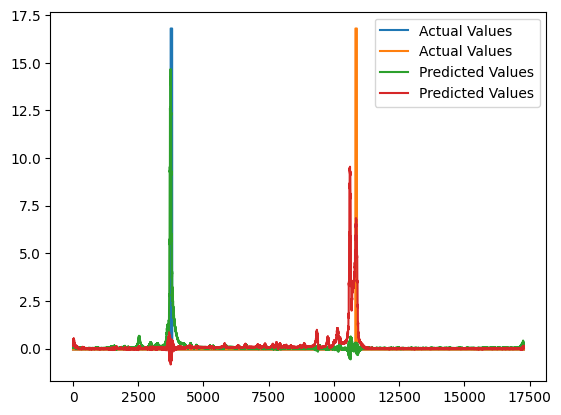

In [22]:
i = 2
# sid = val_series_all.filter(pl.col())
plt.plot(val_y_all[i], label="Actual Values")
print(val_series_all[i])

plt.plot(val_preds_all[i], label="Predicted Values")


plt.legend()
plt.show()

In [23]:
def nms_nikhil(preds_orig, k_orig=150, max_thresh=0.05, max_count=500):
    
    preds=preds_orig.copy()
    preds = np.convolve(preds, np.array([0.2, 0.6, 0.2]), mode='same')

    count = 0
    base=6.75
    
    k = k_orig
    prev_max = None

    scores = []
    indices = []
    
    while True:
            
        curr_max_idx = np.argmax(preds)
        curr_max = preds[curr_max_idx] 
        
        if (curr_max < max_thresh) or count > max_count:
            break
        
        indices.append(curr_max_idx)
        scores.append(curr_max)
        
        preds[curr_max_idx] = 0
        
        supress_rates = np.logspace(start=0, stop=1, num=k, base=base)/base
        supress_rates[:20] = 0
        # supress_rates[20:] += 0.1

        preds[max(curr_max_idx-k, 0):curr_max_idx] *= supress_rates[:min(k, curr_max_idx-0)][::-1]

        preds[curr_max_idx+1:min(curr_max_idx+k+1, preds.shape[0])] *= supress_rates[:min(k, preds.shape[0]-curr_max_idx-1)]

        prev_max = curr_max
        
        count += 1
        
    return indices, scores

def get_actual_preds(val_preds, val_series_ids, val_steps, type_):
    times = []
    series_ids = []
    scores = []
    scores_y = []
    
    for i in np.arange(len(val_preds)):
        
        vp_i = val_preds[i]
        ser_id = val_series_ids[i]
        
        col_index = 0 if type_ == "onset" else 1
        other_col_index = 1 if type_ == "onset" else 0
        
        preds = vp_i[:, col_index]
        preds_other = vp_i[:, other_col_index]

        height_thresh = 0.05
        
        peaks, peak_scores = nms_nikhil(preds)

        times.extend(val_steps[i][peaks])
        scores.extend(list(peak_scores))
        series_ids.extend([ser_id] * len(peaks))

    return np.array(series_ids), np.array(times), np.array(scores)




def post_process_preds(val_events_df, val_preds, val_series_ids, val_starts_splits, samp_freq, get_score=False):
    
#     val_steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(val_preds.shape[0])])

    val_res = []
    
    prev_ser_id = None
    
    res_steps = []
    res_preds = []
    res_series_ids = []
    
    start = 0
    while start < len(val_preds):
        
        end = start+1
        while end < len(val_preds) and val_series_ids[end] == val_series_ids[start]:
            end += 1
            
        preds = val_preds[start:end]
        
        steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(start, end)])
        preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
        
        res_preds.append(preds)
        res_steps.append(steps)
        res_series_ids.append(val_series_ids[start])
        
        start=end
        
        
#     print(len(res_series_ids), len(res_steps), len(res_preds))

    series_ids_onsets, onsets,  scores_onsets = get_actual_preds(res_preds, res_series_ids, res_steps, 'onset')
    series_ids_wakeups, wakeups,  scores_wakeups =get_actual_preds(res_preds, res_series_ids, res_steps, 'wakeup')
    
    
    onset_preds = pl.DataFrame().with_columns([pl.Series(series_ids_onsets).alias('series_id'),
                                           pl.Series(onsets).cast(pl.Int64).alias('step'),
                                           pl.lit('onset').alias('event'),
                                           pl.Series(scores_onsets).alias('score')])

    wakeup_preds = pl.DataFrame().with_columns([pl.Series(series_ids_wakeups).alias('series_id'),
                                               pl.Series(wakeups).cast(pl.Int64).cast(pl.Int64).alias('step'),
                                               pl.lit('wakeup').alias('event'),
                                               pl.Series(scores_wakeups).alias('score')])
    
    val_preds_df = pl.concat([onset_preds, wakeup_preds]).sort(by=['series_id', 'step'])
    
    if get_score:
        toleranaces = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
        comp_score = metric_fast.comp_scorer(
        val_events_df,
        val_preds_df,
        tolerances = toleranaces,
        )
        return comp_score
    
    else:
        return val_preds_df

In [24]:
%%time
scores = []

for fold_num in range(1, n_folds+1):
    
    test_ser_ids = list(np.unique(val_series_lst[fold_num-1]))


    val_events_df = train_events.filter(pl.col('series_id').is_in(test_ser_ids))
    score = post_process_preds(val_events_df,
                               val_preds_lst[fold_num-1],
                               val_series_lst[fold_num-1],
                               val_starts_splits_lst[fold_num-1],
                               cfg.samp_freq,
                               get_score=True)
    print(score)
    scores.append(score)
    
np.mean(scores), np.std(scores)

0.8104805500602077
0.8905906691126992
0.8447164398555154
0.8444944727192153
0.8127955505922131
0.7953424761182206
0.7191334872219555
0.8555174238499521
0.8498881563788429
0.7909417592262871
CPU times: user 35.4 s, sys: 43.5 s, total: 1min 18s
Wall time: 1min 17s


(0.8213900985135109, 0.04483117438553839)

In [25]:
val_preds_df = post_process_preds(val_events_df, val_preds_all, val_series_all, val_starts_splits_all, cfg.samp_freq, get_score=False)

In [26]:
def round_to_nearest_multiple(df, column_name='step'):
    df[column_name] = df[column_name].apply(lambda x: x+1 if x%12==0  else x)
    return df


In [27]:
val_preds_df = round_to_nearest_multiple(val_preds_df.to_pandas())
val_preds_df = pl.DataFrame(val_preds_df)

In [28]:
tolerances = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
               'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}

In [29]:
metric_fast.comp_scorer(train_events, val_preds_df, tolerances=tolerances)

0.811546857079024

In [30]:
val_preds_df.shape

(261376, 4)

In [31]:
preds_partitions  = val_preds_df.partition_by(by=['series_id'], maintain_order=True, as_dict=True)
events_partitions  = val_events_df.partition_by(by=['series_id'], maintain_order=True, as_dict=True)

tolerances = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
               'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}

scores_dict = {}
for ser_id in tqdm(events_partitions.keys()):
    scores_dict[ser_id] = metric_fast.comp_scorer(events_partitions[ser_id], preds_partitions[ser_id],
                                                  tolerances)
    

100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


In [32]:
pd.Series(scores_dict).sort_values()

a596ad0b82aa    0.354350
0a96f4993bd7    0.576204
062dbd4c95e6    0.627559
fa149c3c4bde    0.729653
aa81faa78747    0.731018
de6fedfb6139    0.742531
ad425f3ee76d    0.781065
c68260cc9e8f    0.793531
51c49c540b4e    0.797994
c908a0ad3e31    0.803042
83fa182bec3a    0.806568
bfe41e96d12f    0.810714
0cd1e3d0ed95    0.849057
1c7c0bad1263    0.855242
e2b60820c325    0.869627
c8053490cec2    0.882568
e586cbfa7762    0.891209
eec197a4bdca    0.891943
ebb6fae8ed43    0.907523
9ddd40f2cb36    0.920076
87a6cbb7c4ed    0.927780
78569a801a38    0.929197
2b0a1fa8eba8    0.933291
c7d693f24684    0.956661
1b92be89db4c    0.956774
939932f1822d    0.975336
dtype: float64

In [33]:
cfg_attributes_dict = {k: v for k, v in cfg.__dict__.items() if not k.startswith('__') and not callable(v)}
joblib.dump(cfg_attributes_dict, os.path.join(cfg.output_dir, cfg.ver, 'cfg.pkl'))
joblib.dump(model_dct, os.path.join(cfg.output_dir, cfg.ver, 'model_dct.pkl'))

np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_series_all.npy'), val_series_all)


val_preds_df.to_pandas().to_csv(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_df.csv'), index=False)

np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_all.npy'), val_preds_all)
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_y_all.npy'), val_y_all)

In [34]:
import json

meta_json = {
  "title": f"sleep-model-{cfg.ver}",
  "id": f"nikhilmishradev/sleep-model-{cfg.ver}",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}



json.dump(meta_json, open(os.path.join(cfg.output_dir, cfg.ver, 'dataset-metadata.json'), 'w'))

In [35]:
# !rm -r ../outputs/vx/*
# !cp -r {os.path.join(cfg.output_dir, cfg.ver)}/* ../outputs/vx
# !rm ../outputs/vx/val_preds_all.npy ../outputs/vx/val_y_all.npy
# !pip install -q kaggle
# !kaggle datasets create -p ../outputs/vx

Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file cfg.pkl
100%|███████████████████████████████████████████| 119/119 [00:03<00:00, 39.3B/s]
Upload successful: cfg.pkl (119B)
Starting upload for file model_dct.pkl
100%|██████████████████████████████████████| 4.00k/4.00k [00:02<00:00, 1.77kB/s]
Upload successful: model_dct.pkl (4KB)
Starting upload for file oof_preds.parquet
100%|██████████████████████████████████████| 1.02G/1.02G [01:00<00:00, 18.3MB/s]
Upload successful: oof_preds.parquet (1GB)
Starting upload for file tf_model_fold_1.h5
100%|████████████████████████████████████████| 145M/145M [00:11<00:00, 13.6MB/s]
Upload successful: tf_model_fold_1.h5 (145MB)
Starting upload for file tf_model_fold_10.h5
100%|████████████████████████████████████████| 145M/145M [00:11<00:00, 13.1MB/s]
Upload successful: tf_model_fold_10.h5 (145MB)
Starting upload for file tf_model_fold_2.h5
100%|████████████████████████████████████████| 145M/145M [00:13<00

In [36]:
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_all.npy'), val_preds_all)
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_y_all.npy'), val_y_all)

In [37]:
cfg.ver

'fm-v21-final'